In [1]:
import numpy as np
import os
import torch
import glob
import matplotlib.pyplot as plt
import warnings
from PIL import Image
import time
import cv2

In [2]:
from grounded_sam_utils import *
from utils_sd import *
from poc_pipeline import PlacingObjectsInContextPipeline

from path_utils import *

/home/pdejorge/Grounded-Segment-Anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [3]:
poc_pipeline = PlacingObjectsInContextPipeline(
                                         gdino_ckpt_path,
                                         gdino_config,
                                         sam_ckpt,
                                         inpainting_model_pipeline=sd_inp_v2)

/home/pdejorge/anaconda3/envs/stable_dif/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/pdejorge/anaconda3/envs/stable_dif/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


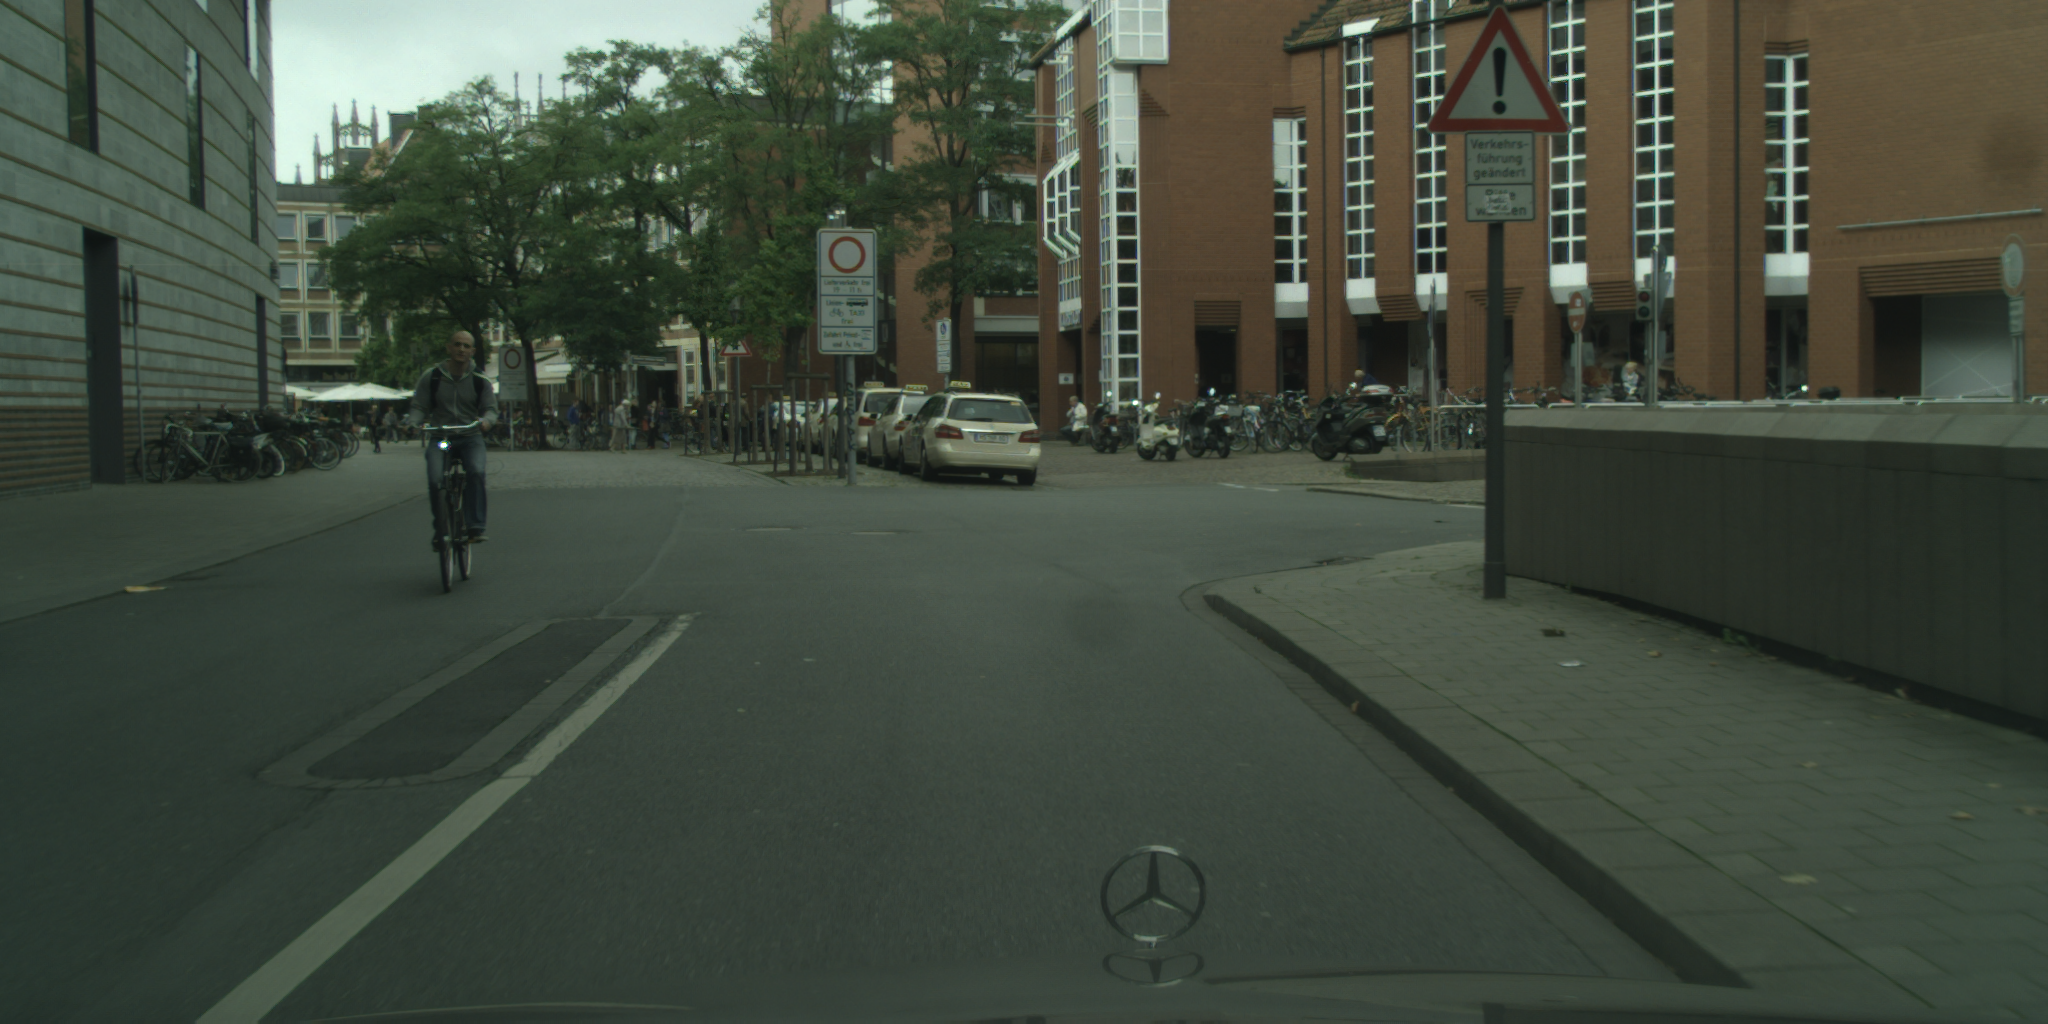

In [4]:
# Replace with equivalent path to Cityscapes (or any desired image)
root = "/gfs-ssd/project/clara/data/Cityscapes/leftImg8bit/val/munster/"

input_image_list = glob.glob(f'{root}/*.png')
image_path = input_image_list[31]
input_image = Image.open(image_path).convert("RGB")

input_image

/home/pdejorge/anaconda3/envs/stable_dif/lib/python3.10/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/pdejorge/anaconda3/envs/stable_dif/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Found mask in 0.6584055423736572 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

Blurring edges
37.49462604522705


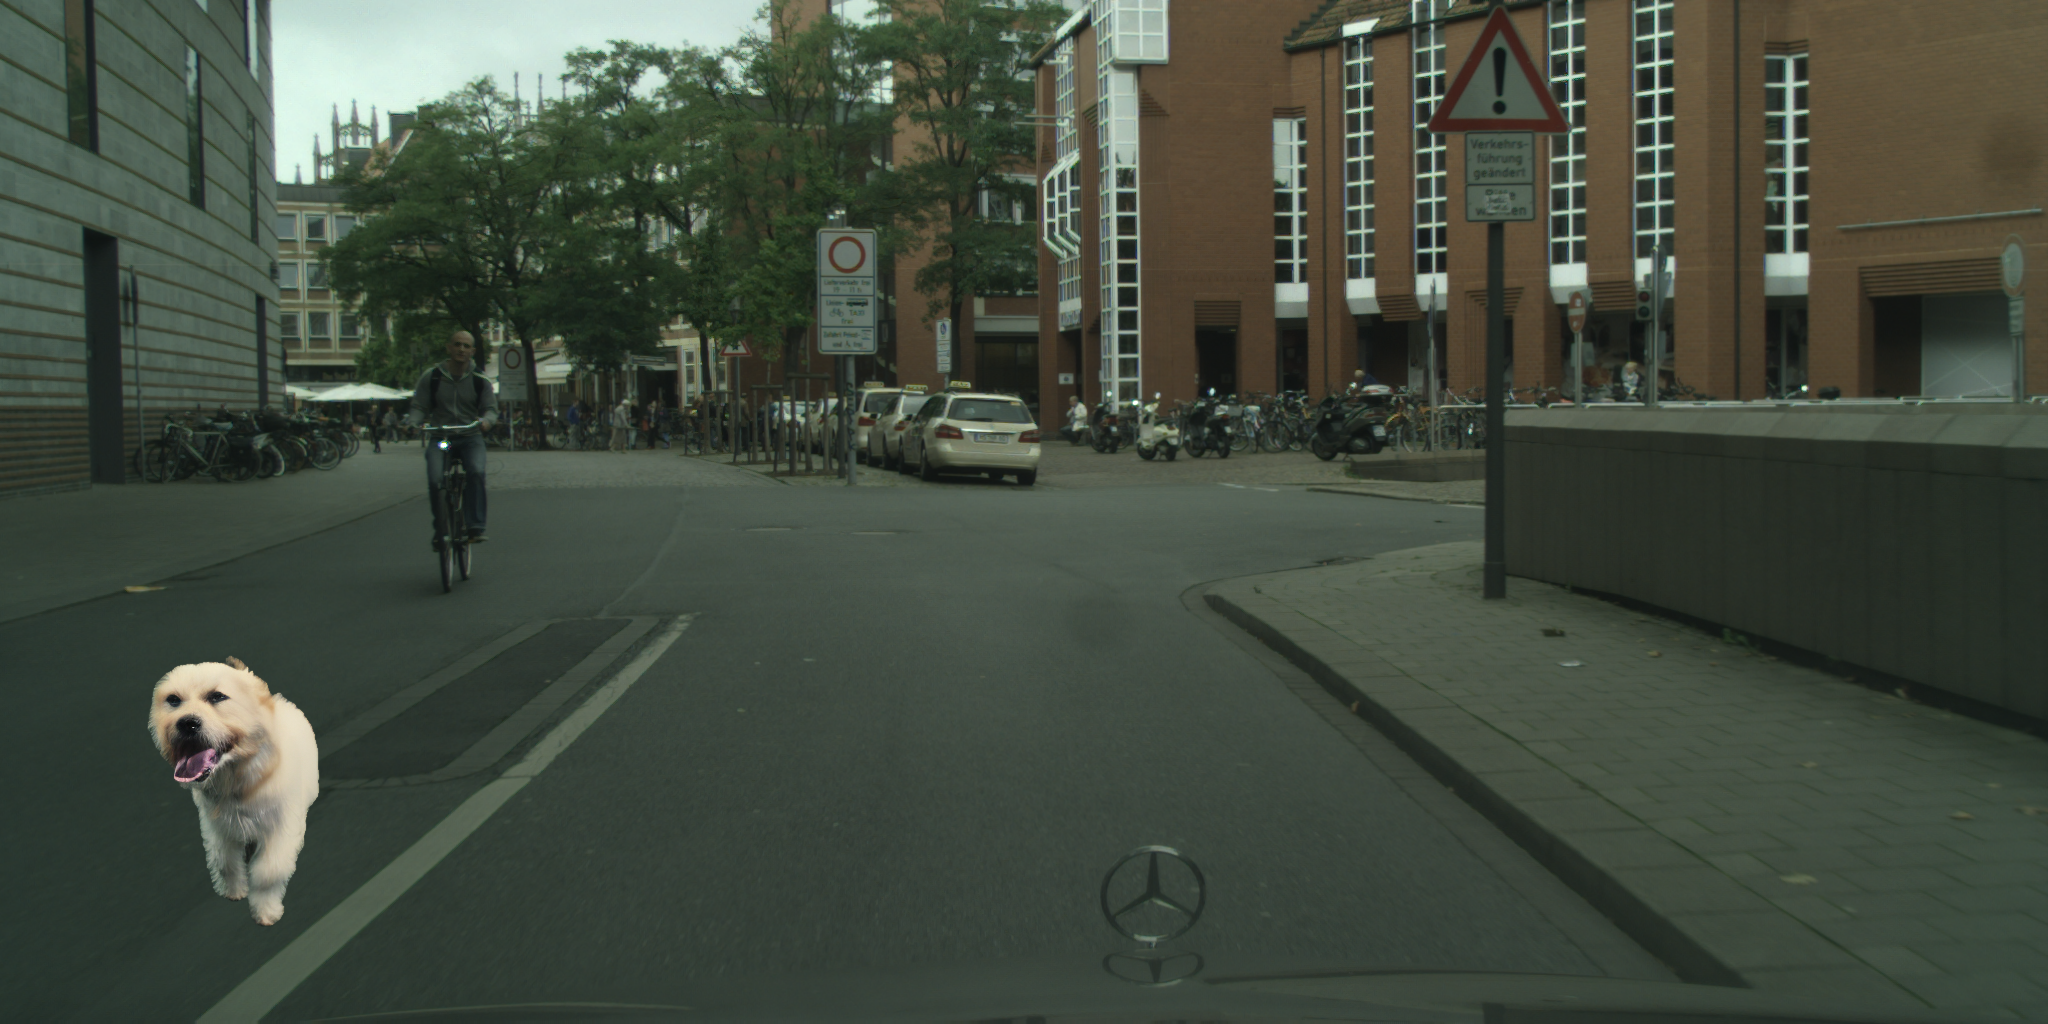

In [5]:
obj = 'dog'
object_prompt = [obj]
inpaint_prompt = f'A good photo of a {obj}'
negative_prompt = None
location_prompt = 'road'
box_min = 200
box_max = 400
mask_thr = 0.5
blur_std = 1
img_crop_size = 512
seed = 123 # Modify to get different results

init_time = time.time()
inpainted_image, object_bbox, object_masks = poc_pipeline.inpaint_image(input_image, inpaint_prompt,
                                                                negative_prompt=negative_prompt,
                                                                object_prompt=object_prompt,
                                                                img_crop_size=img_crop_size,
                                                                location_prompt=location_prompt,
                                                                box_min=box_min,
                                                                box_max=box_max,
                                                                mask_thr=mask_thr,
                                                                blur_std=blur_std,
                                                                seed=seed)

eta = time.time() - init_time
print(eta)
inpainted_image

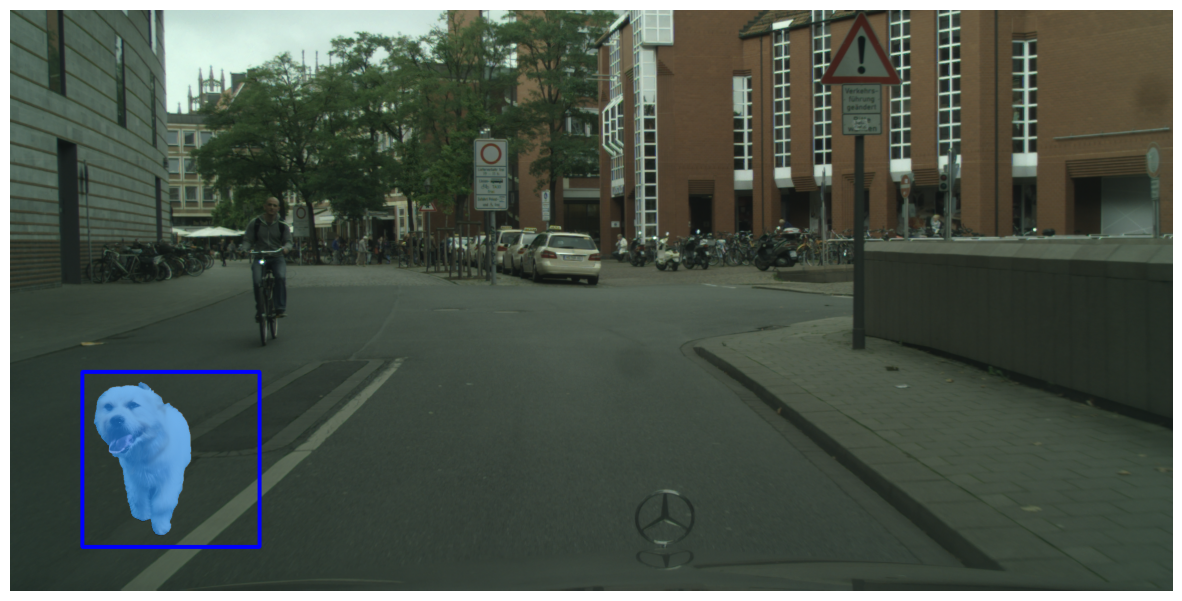

In [6]:
# Get inpainting region for reference
mask = poc_pipeline.inpainting_full_mask.astype('uint8')

contours,_ = cv2.findContours(mask.copy(), 1, 1)
rect = cv2.minAreaRect(contours[0])

box = cv2.boxPoints(rect)
box = np.int0(box)
rect2 = cv2.drawContours(np.array(inpainted_image),[box],0,(0,0,255),5)

colors = [np.array([30/255, 144/255, 255/255, 0.6]),
          np.array([255/255, 144/255, 10/255, 0.6]),
          np.array([114/255, 144/255, 114/255, 0.6])]

for ii, prompt in enumerate(object_masks.keys()):
    plt.figure(figsize=(15,15))
    plt.imshow(rect2)
    mask = object_masks[prompt].sum(dim=0).cpu().numpy()
    mask = (mask > 0).astype('uint8')

    show_mask(mask, plt.gca(), color=colors[ii])
    plt.axis('off');